#### Reading the data from UCI SMS Spam Collection DataSet

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
dataset = pd.read_csv('SMSSpamCollection', sep='\t',header=None, names=['Label', 'SMS'])

print(dataset.shape)
dataset.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
dataset['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

#### Preprocessing the data

In [4]:
# We randomize the data to make sure the results are reproducable.(We randomize the entire dataset.)
data_randomized = dataset.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

#Now splitting the whole dataset into 80:20 ratio. 80 : training, 20: testing.
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [5]:
training_set['Label'].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [6]:
test_set['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64



####Below we remove the punctuations from each message and convert them to lower case to avoid duplicates such as "APPLES" and "apples".

In [7]:
# Before cleaning
training_set.head(1)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"


In [8]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ') # Removes punctuation
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head(1)

,Label,SMS
0,ham,yep by the pretty sculpture


####Below the vocabulary of the training dataset has been created and to prevent duplicates set function was used.

In [9]:
training_set['SMS'] = training_set['SMS'].str.split() # transform the SMS column to a list, split the SMS at space char.

vocabulary = []
for sms in training_set['SMS']:
   for word in sms:
      vocabulary.append(word) # iterating over each message and appending the words to vocabulary list.

vocabulary = list(set(vocabulary)) # To remove the duplicates 
len(vocabulary) 

7783

####Above we can see that we have 7783 unique words in our dataset.

####Creating dictionary containing words as the key and word counts per message. Later a df is formed using this.

In [10]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
   for word in sms:
      word_counts_per_sms[word][index] += 1
      
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,seat,140,lara,doctor,treacle,sam,hunting,satisfy,prasanth,050703,liked,str8,subject,off,noe,passport,tirupur,troubleshooting,vikky,lmao,sitting,elliot,gorgeous,doesnt,furniture,laughing,t4get2text,tips,goggles,athome,ahhhh,mustprovide,differ,cooperative,overtime,envelope,benefits,gone,come,practical,...,working,chillaxin,24hrs,shouldn,gbp4,starshine,progress,christmassy,bcums,alle,perumbavoor,concentration,overheating,09061104276,nutter,vomitin,club4,maat,fondly,u,300603,through,shot,gray,maniac,authorise,july,consider,causing,frndsship,paces,08719180248,siguviri,spontaneously,musical,num,seems,poboxox36504w45wq,practice,83049
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Above we can see the label column was missing, so we use concat function the concatenate the Dataframe we just build with the DataFrame containing the training set.

In [11]:
training_set_clean = pd.concat([training_set, word_counts], axis=1) 
training_set_clean.head()

,Label,SMS,seat,140,lara,doctor,treacle,sam,hunting,satisfy,prasanth,050703,liked,str8,subject,off,noe,passport,tirupur,troubleshooting,vikky,lmao,sitting,elliot,gorgeous,doesnt,furniture,laughing,t4get2text,tips,goggles,athome,ahhhh,mustprovide,differ,cooperative,overtime,envelope,benefits,gone,...,working,chillaxin,24hrs,shouldn,gbp4,starshine,progress,christmassy,bcums,alle,perumbavoor,concentration,overheating,09061104276,nutter,vomitin,club4,maat,fondly,u,300603,through,shot,gray,maniac,authorise,july,consider,causing,frndsship,paces,08719180248,siguviri,spontaneously,musical,num,seems,poboxox36504w45wq,practice,83049
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



##Creating the Spam Filter

First we calculate constants:

In [12]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean) #p of spam/ total
p_ham = len(ham_messages) / len(training_set_clean) # p of ham /total

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

Next we calculate parameters:

In [13]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
   n_word_given_spam = spam_messages[word].sum() # spam_messages already defined
   p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
   parameters_spam[word] = p_word_given_spam

   n_word_given_ham = ham_messages[word].sum() # ham_messages already defined
   p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
   parameters_ham[word] = p_word_given_ham

####Classifying a New message :
1) The function takes the message which has to be classified as an input.

2) Calculates :

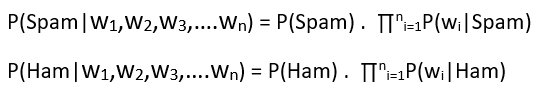

3) Compares the above value and whichever is found to be greater than other one is the final label for the message.

In [16]:
def classify(message):
   '''
   message: a string
   '''

   message = re.sub('\W', ' ', message) #remove punctuations 
   message = message.lower().split() # Split the message into words and convert the words to lowercase 

   p_spam_given_message = p_spam # prior probability for spam
   p_ham_given_message = p_ham # prior probability for ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham: 
         p_ham_given_message *= parameters_ham[word]

   print('P(Spam|message):', p_spam_given_message)
   print('P(Ham|message):', p_ham_given_message)

   if p_ham_given_message > p_spam_given_message:
      print('Label: Ham')
   elif p_ham_given_message < p_spam_given_message:
      print('Label: Spam')
   else:
      print('Equal proabilities, have a human classify this!')

classify('Winner. Claim your free reward today. Winner')

P(Spam|message): 5.039492364686131e-21
P(Ham|message): 3.345594114328508e-28
Label: Spam


In [17]:
classify("Sounds good Rob, see you there tonight")

P(Spam|message): 4.799483208051815e-26
P(Ham|message): 1.2056621248378029e-21
Label: Ham


####Measuring Accuracy:
The remaining 20% of the dataset which was assigned as testdata in the beginning.

In [18]:
def classify_test_set(message):
   '''
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham:
         p_ham_given_message *= parameters_ham[word]

   if p_ham_given_message > p_spam_given_message:
      return 'ham'
   elif p_spam_given_message > p_ham_given_message:
      return 'spam'
   else:
      return 'needs human classification'

In [19]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [20]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
   row = row[1]
   if row['Label'] == row['predicted']:
      correct += 1

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', (correct/total)*100,"%")

Correct: 1100
Incorrect: 14
Accuracy: 98.74326750448833 %
